<a href="https://colab.research.google.com/github/rtajeong/ChatGPT_for_Management/blob/main/10_stock_price_prediction_with_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Prediction Using GPT
- Objective: Predict the next day's stock closing price using past data.
- Example: using time-series data forecasting in combination with fine-tuned GPT models.

## Data Preparation

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Fetch Historical Stock Data

def fetch_stock_data(stock_symbol, start_date, end_date):
    data = yf.download(stock_symbol, start=start_date, end=end_date)
    data = data[['Close']].copy()  # Ensure we copy the dataframe
    data.reset_index(inplace=True)  # Reset MultiIndex to single index
    data.columns = ['Date', 'Close']  # Rename columns for clarity
    data['Returns'] = data['Close'].pct_change()  # Calculate returns
    data.dropna(inplace=True)  # Drop NaN values
    return data

stock_symbol = 'AAPL'
data = fetch_stock_data(stock_symbol, '2020-01-01', '2023-01-01')
print()
print(data[:3])

[*********************100%***********************]  1 of 1 completed


        Date      Close   Returns
1 2020-01-03  72.088287 -0.009722
2 2020-01-06  72.662712  0.007968
3 2020-01-07  72.320976 -0.004703


In [ ]:
# Convert stock prices into a text sequence for GPT

sequence = ""
for i, price in enumerate(data['Close']):
    sequence += f"Day {i}: {price}\n"

# Save the sequence to a text file
data_file = "stock_data.txt"
with open(data_file, "w") as f:
    f.write(sequence)

!head -3 stock_data.txt

Day 0: 72.08828735351562
Day 1: 72.66271209716797
Day 2: 72.32097625732422


## 1_Direct GPT conversation
- 다음과 같은 여러 방법이 있기 때문에 구체적인 방법까지 제시해 주는 게 좋을 것임.
  - 단순 추세 분석 (Simple Trend Analysis)
  - 이동 평균 (Moving Average)
  - 단순 선형 회귀 (Linear Regression)
  - 머신러닝/딥러닝 모델 (ML/DL Models)

```
- prompt:
  " Based on the following historical stock prices:
    Day 1: \$150
    Day 2: \$152
    Day 3: \$154
    Day 4: \$153
    Day 5: \$155
    What will be the stock price on Day 6? "

- response:
  " 주어진 데이터의 단순 추세 분석 결과, Day 6의 주가는 약 $156.25로 예측됩니다.
  그러나, 시장은 여러 요인에 의해 영향을 받으므로 예측에 대한 불확실성이 존재합니다."
```

## 2_Using Open AI API

In [ ]:
import openai

# Set your OpenAI API key
from google.colab import drive
drive.mount('/content/drive')

api_key_file = '/content/drive/My Drive/Colab Notebooks/api_key.txt'

with open(api_key_file, 'r') as f:
    api_key = f.read().strip()

# import openai
# import os
# os.environ['OPENAI_API_KEY'] = api_key

Mounted at /content/drive


In [ ]:
client = openai.OpenAI(api_key=api_key)

# Define the prompt
prompt = """
Based on the following historical stock prices:
Day 1: $150
Day 2: $152
Day 3: $154
Day 4: $153
Day 5: $155
What will be the stock price on Day 6?
"""

# Send the prompt to GPT
response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[{"role": "user",
               "content": prompt,}]
)

# Extract the generated text
predicted_price = response.choices[0].message.content
print(f"Predicted Stock Price: {predicted_price}")


Predicted Stock Price: There is not enough information to accurately predict the stock price on Day 6 based solely on the historical prices provided. Stock prices are influenced by various factors such as market trends, company performance, economic conditions, and investor sentiment. It is best to conduct a thorough analysis using additional data and information before making any predictions about future stock prices.


In [ ]:
predicted_price

'There is not enough information to accurately predict the stock price on Day 6 based solely on the historical prices provided. Stock prices are influenced by various factors such as market trends, company performance, economic conditions, and investor sentiment. It is best to conduct a thorough analysis using additional data and information before making any predictions about future stock prices.'

## 3_Fine-tuned GPT model
- 개념: GPT-2 또는 GPT-3를 특정 주가 데이터를 기반으로 미세 조정하여 사용.
  - 장점:
    - 특정 데이터에 맞게 성능 향상.
    - 재학습 없이 직접 사용 가능.
  - 단점:
    - 미세 조정에는 데이터 준비와 추가 훈련 시간이 필요.
    - 하드웨어 요구 사항이 있을 수 있음.
- 본 예제의 경우:
  - 입력(X): 최근 5일간의 주가 데이터
  - 출력(y): 다음 날(Day 6)의 주가 예측

In [ ]:
!pip install transformers datasets

In [ ]:
pd.concat([data.head(3), data.tail(3)])

,Date,Close,Returns
1,2020-01-03,74.357498,-0.009722
2,2020-01-06,74.949997,0.007968
3,2020-01-07,74.597504,-0.004703
753,2022-12-28,126.040001,-0.030685
754,2022-12-29,129.610001,0.028324
755,2022-12-30,129.929993,0.002469


- Prepare the Dataset
  - Format the data for GPT fine-tuning. We convert stock prices into a sequence of days with the next day’s price as the target.

In [ ]:
# Create sequences for training
sequence_length = 5  # Number of days in input sequence
formatted_data = []

for i in range(len(data) - sequence_length):
    input_sequence = ", ".join(
        [f"Day {j+1}: ${data['Close'].iloc[i+j].item():.2f}" for j in range(sequence_length)]
    )
    target = f"${data['Close'].iloc[i + sequence_length].item():.2f}"
    formatted_data.append(f"{input_sequence} -> {target}")

# Save formatted data to a text file
with open("train_data.txt", "w") as f:
    for line in formatted_data:
        f.write(line + "\n")

print("Training data saved to 'train_data.txt'.")

Training data saved to 'train_data.txt'.


In [ ]:
input_sequence, target

('Day 1: $130.85, Day 2: $130.49, Day 3: $128.68, Day 4: $124.73, Day 5: $128.26',
 '$128.58')

In [ ]:
formatted_data[-3:]

['Day 1: $132.30, Day 2: $135.45, Day 3: $132.23, Day 4: $131.86, Day 5: $130.03 -> $126.04',
 'Day 1: $135.45, Day 2: $132.23, Day 3: $131.86, Day 4: $130.03, Day 5: $126.04 -> $129.61',
 'Day 1: $132.23, Day 2: $131.86, Day 3: $130.03, Day 4: $126.04, Day 5: $129.61 -> $129.93']

- Fine-tune GPT
  - fine-tuning에서는 기존의 학습된 가중치가 유지되며, 새로운 데이터에 맞게 조금씩 조정된다. (모델의 파라미터가 update 된다)
  - 따라서, 기존에 학습된 언어적 패턴이나 구조는 그대로 유지하면서 새로운 데이터 특성을 반영하게 된다.

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, TextDataset, DataCollatorForLanguageModeling, TrainingArguments, Trainer

# Load tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')  # gpt2 tokenizer (converts text into token IDs and vice versa)
model = GPT2LMHeadModel.from_pretrained('gpt2')    # 사전 학습된 가중치(Pre-trained Weights)를 불러온다

# Load the dataset
train_dataset = TextDataset(                       # helper class to load text data for training
    tokenizer=tokenizer,
    file_path='train_data.txt',  # Path to training data
    block_size=128,              # Max token length per sequence
)

# Create a data collator (data batch 를 구성하는  작업)
data_collator = DataCollatorForLanguageModeling(    # Prepares batches of text for training
    tokenizer=tokenizer,
    mlm=False,  # Causal language modeling (no masking)
)

# Set up training arguments
training_args = TrainingArguments(   # Configuration for training: epochs, batch size, ...
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=3,              #
    per_device_train_batch_size=4,   #
    save_steps=500,
    save_total_limit=2,
    learning_rate=5e-5,              #
    report_to="none",       # disable wandb or other loggers
)

# Fine-tune the model (모델의 파라미터가 업데이트됨)
trainer = Trainer(          # High-level API to train and fine-tune models
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,  # 도메인 특화 학습 데이터셋
)

trainer.train()

# Save the fine-tuned model
trainer.save_model("./fine_tuned_gpt2")
tokenizer.save_pretrained("./fine_tuned_gpt2")

print("Model fine-tuning complete and saved to './fine_tuned_gpt2'.")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


Step,Training Loss


Model fine-tuning complete and saved to './fine_tuned_gpt2'.


- Prepare Test Data

In [ ]:
test_data = data[-(sequence_length + 10):]  # Use the last 10 days for testing
test_sequences = []

for i in range(len(test_data) - sequence_length):
    input_sequence = ", ".join(
        [f"Day {j+1}: ${test_data['Close'].iloc[i+j].item():.2f}" for j in range(sequence_length)]
    )
    target = test_data['Close'].iloc[i + sequence_length].item()
    test_sequences.append((input_sequence, target))

In [ ]:
test_sequences

[('Day 1: $142.16, Day 2: $144.49, Day 3: $145.47, Day 4: $143.21, Day 5: $136.50',
  134.50999450683594),
 ('Day 1: $144.49, Day 2: $145.47, Day 3: $143.21, Day 4: $136.50, Day 5: $134.51',
  132.3699951171875),
 ('Day 1: $145.47, Day 2: $143.21, Day 3: $136.50, Day 4: $134.51, Day 5: $132.37',
  132.3000030517578),
 ('Day 1: $143.21, Day 2: $136.50, Day 3: $134.51, Day 4: $132.37, Day 5: $132.30',
  135.4499969482422),
 ('Day 1: $136.50, Day 2: $134.51, Day 3: $132.37, Day 4: $132.30, Day 5: $135.45',
  132.22999572753906),
 ('Day 1: $134.51, Day 2: $132.37, Day 3: $132.30, Day 4: $135.45, Day 5: $132.23',
  131.86000061035156),
 ('Day 1: $132.37, Day 2: $132.30, Day 3: $135.45, Day 4: $132.23, Day 5: $131.86',
  130.02999877929688),
 ('Day 1: $132.30, Day 2: $135.45, Day 3: $132.23, Day 4: $131.86, Day 5: $130.03',
  126.04000091552734),
 ('Day 1: $135.45, Day 2: $132.23, Day 3: $131.86, Day 4: $130.03, Day 5: $126.04',
  129.61000061035156),
 ('Day 1: $132.23, Day 2: $131.86, Day 3

- Generate Predictions
- tokenizer.encode(): 텍스트(sequence)를 숫자 토큰 시퀀스로 변환.
  - 예: "Hello, world!" → [15496, 11, 995]
  - 각 숫자는 GPT 모델의 어휘(vocabulary)에서 해당 단어에 해당하는 인덱스.
  - return_tensors="pt": PyTorch 텐서 형식으로 반환. (PyTorch 기반 모델에 입력하기 위해 필요.), 예: tensor([[15496, 11, 995]]).
- model.generate(): GPT 모델이 입력 텍스트를 기반으로 새로운 텍스트를 생성
  - input_ids: 모델에 입력으로 제공되는 토큰 시퀀스.
  - max_length: 생성되는 텍스트의 최대 길이.
  - temperature=0.7: 생성 텍스트의 다양성을 조절 (높을수록 창의적)
  - num_return_sequences=1: 모델이 생성할 텍스트 시퀀스의 수 (1로 설정 시 한 번에 하나의 텍스트 시퀀스만 반환)
- tokenizer.decode(): 모델이 생성한 토큰 시퀀스를 사람이 읽을 수 있는 텍스트로 변환
  - 예: [15496, 11, 995] → "Hello, world!"

In [ ]:
import re

# Load fine-tuned model
tokenizer = GPT2Tokenizer.from_pretrained('./fine_tuned_gpt2')
model = GPT2LMHeadModel.from_pretrained('./fine_tuned_gpt2')

predicted_values = []
actual_values = []

for input_sequence, target in test_sequences:
    # Tokenize and predict
    input_ids = tokenizer.encode(input_sequence + " ->", return_tensors='pt')
    output = model.generate(input_ids,
                            max_length=50,
                            num_return_sequences=1,
                            pad_token_id=tokenizer.eos_token_id)

    # Decode and extract the predicted value
    predicted_text = tokenizer.decode(output[0], skip_special_tokens=True)
    match = re.search(r"->\s*\$(\d+\.\d+)", predicted_text)
    if match:
        predicted_value = float(match.group(1))   # the first captured group defined in the regular expression
        predicted_values.append(predicted_value)
        actual_values.append(target)

In [ ]:
print(match)
match.group(0), match.group(1)

<re.Match object; span=(79, 89), match='-> $128.81'>


('-> $128.81', '128.81')

In [ ]:
actual_values[:5], predicted_values[:5], len(actual_values), len(predicted_values)

([134.50999450683594,
  132.3699951171875,
  132.3000030517578,
  135.4499969482422,
  132.22999572753906],
 [136.81, 133.81, 132.72, 132.03, 134.81],
 10,
 10)

- Evaluate Performance

RMSE: 2.61
MAE: 2.18


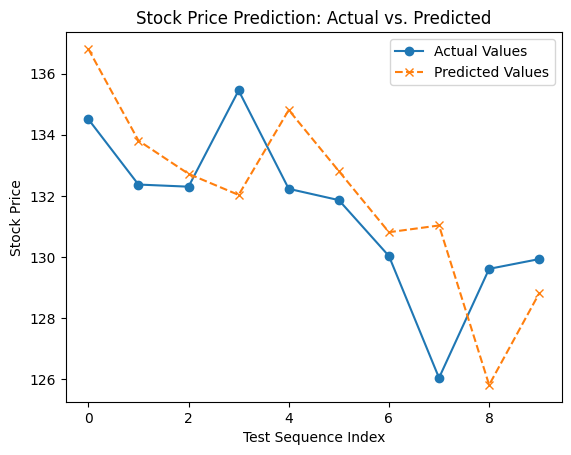

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Calculate RMSE and MAE
rmse = mean_squared_error(actual_values, predicted_values)**0.5
mae = mean_absolute_error(actual_values, predicted_values)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# Plot Actual vs. Predicted Values
plt.plot(actual_values, label="Actual Values", marker="o")
plt.plot(predicted_values, label="Predicted Values", marker="x", linestyle="--")
plt.title("Stock Price Prediction: Actual vs. Predicted")
plt.xlabel("Test Sequence Index")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

- It seems that the predicted values (orange dashed line) lag the actual values (blue line) by one period, which means the model is consistently predicting the previous day's stock price for the current day.
- To improve performance:
  - Enhance Input Data: add mode features like volume, technical indicator, sentiment scores, and use longer sequence
  - Use better model
  - Incorporate Statistical Models:
  - Increase Training Data:


## 4_Pre-trained GPT (without fine tuning)
  - just skip the fine-tuning precess in the previous example

RMSE: 3.45
MAE: 2.64


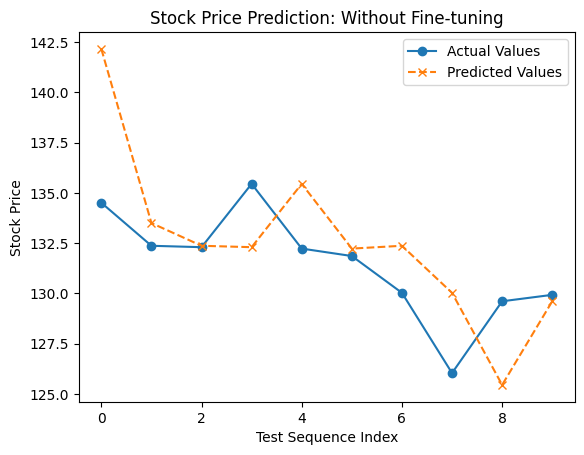

In [ ]:
# Load tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

# prepare test data

test_data = data[-(sequence_length + 10):]  # Use the last 10 days for testing
test_sequences = []

for i in range(len(test_data) - sequence_length):
    input_sequence = ", ".join(
        [f"Day {j+1}: ${test_data['Close'].iloc[i+j].item():.2f}" for j in range(sequence_length)]
    )
    target = test_data['Close'].iloc[i + sequence_length].item()
    test_sequences.append((input_sequence, target))

# generate predictions

predicted_values = []
actual_values = []

for input_sequence, target in test_sequences:
    # Tokenize and predict
    input_ids = tokenizer.encode(input_sequence + " ->", return_tensors='pt')
    output = model.generate(input_ids,
                            max_length=50,
                            num_return_sequences=1,
                            pad_token_id=tokenizer.eos_token_id)

    # Decode and extract the predicted value
    predicted_text = tokenizer.decode(output[0], skip_special_tokens=True)
    match = re.search(r"->\s*\$(\d+\.\d+)", predicted_text)
    if match:
        predicted_value = float(match.group(1))   # the first captured group defined in the regular expression
        predicted_values.append(predicted_value)
        actual_values.append(target)

# Calculate RMSE and MAE
rmse = mean_squared_error(actual_values, predicted_values)**0.5
mae = mean_absolute_error(actual_values, predicted_values)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# Plot Actual vs. Predicted Values
plt.plot(actual_values, label="Actual Values", marker="o")
plt.plot(predicted_values, label="Predicted Values", marker="x", linestyle="--")
plt.title("Stock Price Prediction: Without Fine-tuning")
plt.xlabel("Test Sequence Index")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

- summary:
  1. Fetch stock price data using yfinance.
  2. Prepare the data in the correct format for fine-tuning GPT-2.
  3. Fine-tune GPT-2 on the stock price dataset.
  4. Use the fine-tuned model to predict future stock prices.
  5. Compare predictions with actual values and evaluate performance using RMSE and MAE.

## ARIMA 모델
- 개념: 시계열 데이터를 분석하여 예측.
- 장점:
  - 특정 시계열 데이터에 최적화.
  - 통계적 분석 기반의 안정적인 성능.
- 단점:
  - 데이터가 선형적 관계를 가질 때에만 잘 동작.
  - 비선형 데이터에는 약함.

In [1]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 64.2 MB/s eta 0:00:00


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

def fetch_stock_data(stock_symbol, start_date, end_date):
    data = yf.download(stock_symbol, start=start_date, end=end_date)
    data = data[['Close']].copy()  # Ensure we copy the dataframe
    data.reset_index(inplace=True)  # Reset MultiIndex to single index
    data.columns = ['Date', 'Close']  # Rename columns for clarity
    data.dropna(inplace=True)  # Drop NaN values
    return data

stock_symbol = 'AAPL'
data = fetch_stock_data(stock_symbol, '2020-01-01', '2023-01-01')

df = data[['Date', 'Close']]  # Include 'Date' column


[*********************100%***********************]  1 of 1 completed


<ipython-input-3-31c6e2cdc259>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['Close'].fillna(method='ffill', inplace=True)
<ipython-input-3-31c6e2cdc259>:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df2['Close'].fillna(method='ffill', inplace=True)


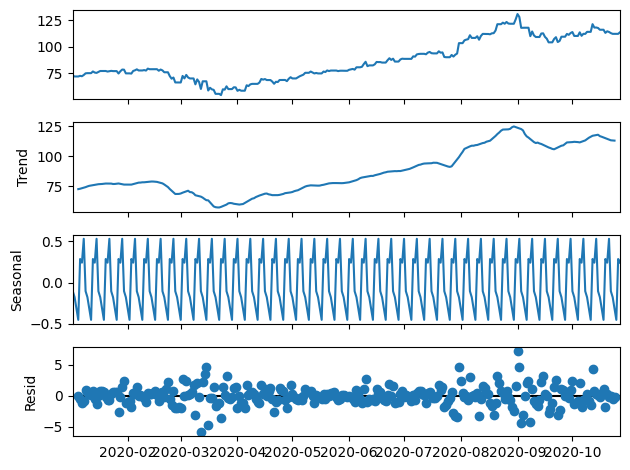

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
df2 = df.copy()
# Convert 'Date' column to datetime and set as index
df2['Date'] = pd.to_datetime(df2['Date'])
df2.set_index('Date', inplace=True)
df2 = df2.asfreq('D')  # daily frequency
# Fill missing values using forward fill
df2['Close'].fillna(method='ffill', inplace=True)
# Perform seasonal decomposition
decomposition = seasonal_decompose(df2[:300], model='additive')  # first 300
fig = decomposition.plot()
plt.show()

- 정상성 테스트:ARIMA 모델은 정상성을 가정하고 있음.
  - ADF (Augmented Dickey-Fuller) Test

In [4]:
# 정상성 테스트

from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] > 0.05:
    print("Data is not stationary")
else:
    print("Data is stationary")

ADF Statistic: -1.8889079375984732
p-value: 0.3372970235967753
Data is not stationary


<Axes: >

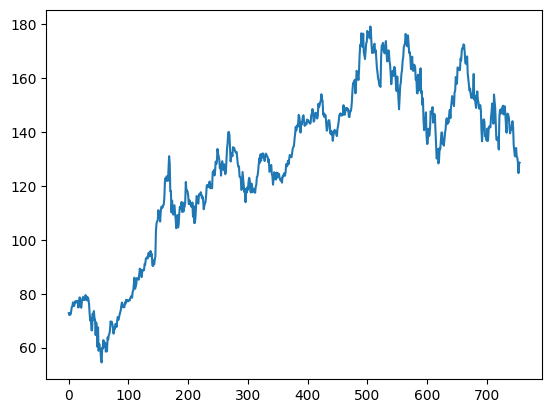

In [5]:
data['Close'].plot()

- 결과:
  - p-value > 0.05: 데이터가 정상성을 만족하지 않음.
  - p-value <= 0.05: 정상성 만족.

- 데이터 변환

In [6]:
# 데이터 변환
# 차분(Differencing): 정상성이 부족한 경우, 차분을 수행

data['Close_Diff'] = data['Close'].diff().dropna()  # 시계열 데이터의 차분 계산

result = adfuller(data['Close_Diff'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] > 0.05:
    print("Data is not stationary after first differencing")
else:
    print("Data is stationary after first differencing")

ADF Statistic: -29.167875105656453
p-value: 0.0
Data is stationary after first differencing


<Axes: >

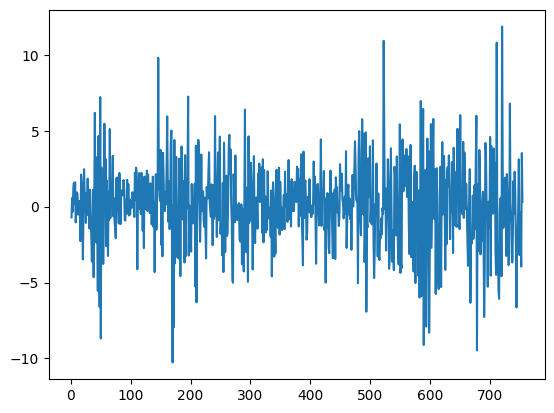

In [7]:
data['Close_Diff'].plot()

- 결과:
  - ADF Statistic: 매우 작은 값, 정상성을 강하게 만족함.
  - p-value: 0.05보다 훨씬 작음
  - 귀무가설(H₀: 데이터는 정상적이지 않다)을 기각.
  - 데이터는 정상적(Stationary)이라고 결론.

- 파라미터 조정
  - Auto-ARIMA 사용: Auto-ARIMA를 사용하여 최적의 파라미터를 찾습니다

In [8]:
!pip install pmdarima

In [9]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # 경고 무시

In [10]:
# Auto-ARIMA를 사용하여 최적의 (p, d, q)를 자동으로 선택
from pmdarima import auto_arima

stepwise_fit = auto_arima(data['Close'], seasonal=False, trace=True)
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3671.878, Time=10.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3669.138, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3668.274, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3668.101, Time=1.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3667.687, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3669.264, Time=2.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 14.027 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  756
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1832.843
Date:                Sat, 11 Jan 2025   AIC                           3667.687
Time:                        14:16:29   BIC                           3672.313
Sample:                             0   HQIC                          3669.469
        

In [16]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Step 1: Fetch Historical Stock Data
def fetch_stock_data(stock_symbol, start_date, end_date):
    data = yf.download(stock_symbol, start=start_date, end=end_date)
    data = data[['Close']].copy()  # Ensure we copy the dataframe
    data.reset_index(inplace=True)  # Reset MultiIndex to single index
    data.columns = ['Date', 'Close']  # Rename columns for clarity
    data.dropna(inplace=True)  # Drop NaN values
    return data

stock_symbol = 'AAPL'
data = fetch_stock_data(stock_symbol, '2020-01-01', '2023-12-31')

# Step 2: Prepare Data for ARIMA

df = data[['Date', 'Close']]  # Include 'Date' column

# Step 3: Split Data into Training and Test Sets
split_index = int(len(df) * 0.8)  # 80% for training, 20% for testing
train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

[*********************100%***********************]  1 of 1 completed


In [17]:
# Step 4: Auto-ARIMA to Find Optimal Parameters

stepwise_fit = auto_arima(train_data['Close'], seasonal=False, trace=True)
optimal_order = stepwise_fit.order  # (p, d, q)
print(f"Optimal ARIMA Order: {optimal_order}")

# Step 5: Fit ARIMA Model on Training Data

model = ARIMA(train_data['Close'], order=optimal_order)
# model = ARIMA(train_data['Close'], order=(7,1,10))   # 수동
model_fit = model.fit()
print(model_fit.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3891.661, Time=1.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3888.741, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3887.878, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3887.703, Time=1.61 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3887.722, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3888.861, Time=2.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3889.041, Time=0.63 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3890.828, Time=1.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3886.822, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3888.086, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3888.230, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3886.981, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3890.053, Time=0.49 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 8.965 seconds
Optimal ARIMA Order: (

In [18]:
# Step 6: Predict on Test Data
forecast_diff = model_fit.get_prediction(start=split_index, end=len(df)-1)
predicted_mean = forecast_diff.predicted_mean
confidence_intervals = forecast_diff.conf_int()

predicted_original_scale = predicted_mean   # 차분값이 이미 반영되어 있음.

In [19]:
# Step 7: Combine Predictions with Actual Values
combined_df = pd.concat([train_data, test_data]) # Create combined_df from train_data and test_data
combined_df['Predicted'] = np.nan
combined_df.loc[test_data.index, 'Predicted'] = predicted_original_scale.values # Use test_data.index for alignment

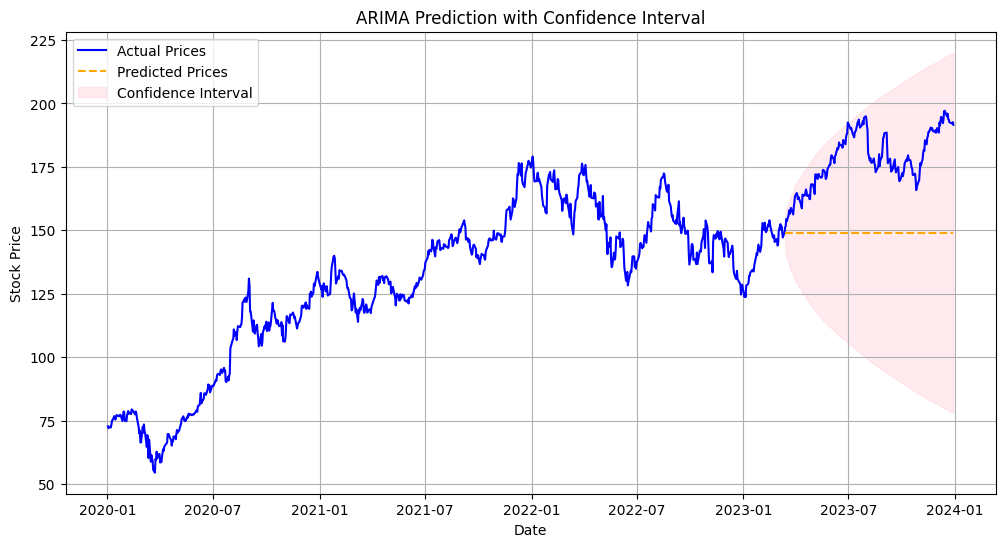

In [20]:
# Step 8: Plot Actual vs Predicted Prices with Confidence Intervals
plt.figure(figsize=(12, 6))
plt.plot(combined_df['Date'], combined_df['Close'], label="Actual Prices", color="blue")  # 실제 값
plt.plot(combined_df['Date'][split_index:], combined_df['Predicted'][split_index:], label="Predicted Prices", color="orange", linestyle="--")  # 예측 값
plt.fill_between(
    combined_df['Date'][split_index:],
    confidence_intervals.iloc[:, 0],
    confidence_intervals.iloc[:, 1],
    color='pink', alpha=0.3, label="Confidence Interval"
)
plt.legend()
plt.title("ARIMA Prediction with Confidence Interval")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.grid()
plt.show()

## ARIMA - 순차적 예측

[*********************100%***********************]  1 of 1 completed


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2300.641, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2299.632, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2295.392, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2295.682, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2301.320, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2297.140, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2297.006, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2299.003, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2297.975, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.266 seconds
Optimal ARIMA Order: (1, 1, 0)


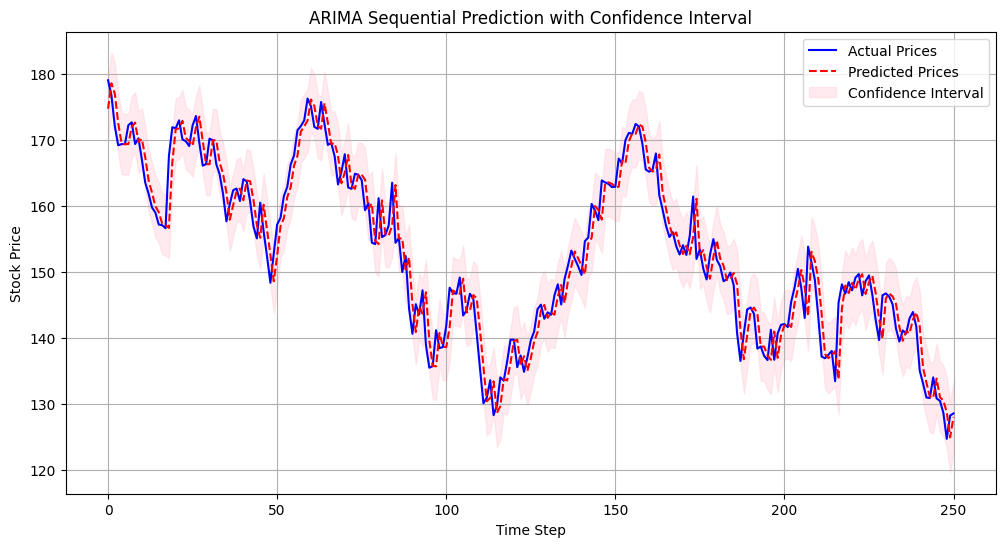

In [21]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Step 1: Fetch Historical Stock Data
def fetch_stock_data(stock_symbol, start_date, end_date):
    data = yf.download(stock_symbol, start=start_date, end=end_date)
    data = data[['Close']].copy()  # Ensure we copy the dataframe
    data.reset_index(inplace=True)  # Reset MultiIndex to single index
    data.columns = ['Date', 'Close']  # Rename columns for clarity
    data.dropna(inplace=True)  # Drop NaN values
    return data

stock_symbol = 'AAPL'
data = fetch_stock_data(stock_symbol, '2020-01-01', '2023-01-01')

# Step 2: Prepare Data for ARIMA
# Use only the 'Close' prices for ARIMA model
df = data[['Close']]

# Step 3: Split Data into Training and Test Sets
# Change test start date to 2022-01-01
split_index = data[data['Date'] == '2022-01-03'].index[0]  # Start test from 2022-01-03
train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

# Step 4: Auto-ARIMA to Find Optimal Parameters
stepwise_fit = auto_arima(train_data['Close'], seasonal=False, trace=True)
optimal_order = stepwise_fit.order
print(f"Optimal ARIMA Order: {optimal_order}")

# Step 5: Sequential Prediction for Test Data
history = list(train_data['Close'])  # 훈련 데이터를 리스트로 변환
predictions = []  # 예측 결과 저장
conf_intervals = []  # 신뢰 구간 저장

for actual in test_data['Close']:
    # ARIMA 모델 학습
    model = ARIMA(history, order=optimal_order)
    model_fit = model.fit()

    # 다음 시점 예측
    forecast = model_fit.get_forecast(steps=1)  # 한 시점만 예측
    predictions.append(forecast.predicted_mean[0])  # 예측 결과 저장
    conf_int = forecast.conf_int()  # 신뢰 구간 저장
    conf_intervals.append(conf_int[0])

    # 실제 값을 history에 추가
    history.append(actual)

# Combine predictions with actual values
combined_df = test_data.copy()
combined_df['Predicted'] = predictions
conf_intervals = np.array(conf_intervals)  # 신뢰 구간을 NumPy 배열로 변환

# Plot Actual vs Predicted Prices with Confidence Intervals
plt.figure(figsize=(12, 6))
plt.plot(test_data['Close'].values, label="Actual Prices", color="blue")  # 실제 값
plt.plot(combined_df['Predicted'].values, label="Predicted Prices", color="red", linestyle="--")  # 예측 값
plt.fill_between(
    range(len(conf_intervals)),
    conf_intervals[:, 0],  # 하한값
    conf_intervals[:, 1],  # 상한값
    color='pink', alpha=0.3, label="Confidence Interval"
)
plt.legend()
plt.title("ARIMA Sequential Prediction with Confidence Interval")
plt.xlabel("Time Step")
plt.ylabel("Stock Price")
plt.grid()
plt.show()


- SARIMAX

[*********************100%***********************]  1 of 1 completed


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2289.429, Time=1.02 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2292.064, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2289.710, Time=0.49 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2289.972, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2293.885, Time=0.03 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=2291.355, Time=1.70 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=2291.342, Time=0.46 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=2290.555, Time=1.00 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2288.072, Time=0.08 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2289.989, Time=0.24 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=2288.955, Time=0.71 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=2289.736, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2287.787, Time=0.08 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2289.695, Time=0.24 sec
 ARIMA(1,1,0)(1,0,1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                  503
Model:             SARIMAX(7, 1, 5)x(1, 1, [1], 12)   Log Likelihood               -1126.780
Date:                              Sat, 11 Jan 2025   AIC                           2283.560
Time:                                      14:23:48   BIC                           2346.476
Sample:                                           0   HQIC                          2308.270
                                              - 503                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3191      1.027      0.311      0.756      -1.695       2.333
ar.L2          1.14

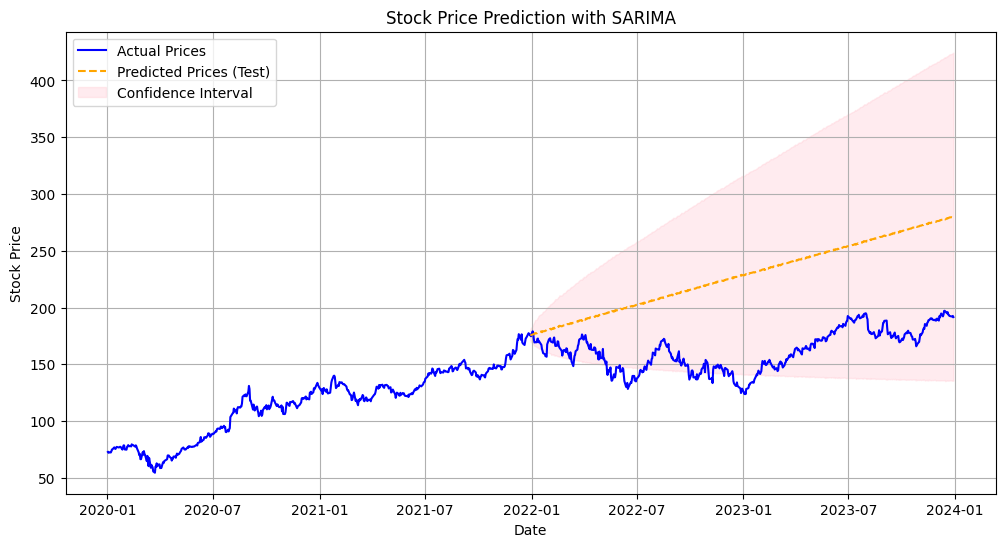

In [22]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Step 1: Fetch Historical Stock Data
def fetch_stock_data(stock_symbol, start_date, end_date):
    data = yf.download(stock_symbol, start=start_date, end=end_date)
    data = data[['Close']].copy()  # Ensure we copy the dataframe
    data.reset_index(inplace=True)  # Reset MultiIndex to single index
    data.columns = ['Date', 'Close']  # Rename columns for clarity
    data.dropna(inplace=True)  # Drop NaN values
    return data

stock_symbol = 'AAPL'
data = fetch_stock_data(stock_symbol, '2020-01-01', '2023-12-31')

# Step 2: Prepare Data for SARIMA
# Use only the 'Close' prices for SARIMA model
df = data[['Close']]

# Step 3: Split Data into Training and Test Sets
split_index = int(len(df) * 0.5)  # 50% for training, 50% for testing
train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

# Step 4: Auto-ARIMA to Find Optimal Parameters
stepwise_fit = auto_arima(
    train_data['Close'],
    start_p=1, start_q=1,
    max_p=5, max_q=5,
    d=None,
    seasonal=True,
    m=12,  # Seasonal period (monthly data)
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    D=None,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# Optimal Parameters
order = stepwise_fit.order
seasonal_order = stepwise_fit.seasonal_order
print(f"Optimal SARIMA Order: {order}, Seasonal Order: {seasonal_order}")

# Step 5: Fit SARIMA Model
#sarima_model = SARIMAX(
#    train_data['Close'],
#    order=order,
#    seasonal_order=seasonal_order
#)
sarima_model = SARIMAX(
    train_data['Close'],
    order=(7, 1, 5),  # Manual p, d, q
    seasonal_order=(1, 1, 1, 12)  # Manual P, D, Q, s
)


sarima_fit = sarima_model.fit()
print(sarima_fit.summary())

# Step 6: Predict on Test Data
forecast = sarima_fit.get_prediction(start=split_index, end=len(df)-1)
predicted_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Step 7: Combine Actual and Predicted Prices into a Single DataFrame
combined_df = data.copy()
combined_df['Predicted'] = np.nan
combined_df.loc[split_index:, 'Predicted'] = predicted_mean.values

# Step 8: Plot Actual vs Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(combined_df['Date'], combined_df['Close'], label="Actual Prices", color="blue")  # Actual prices over the entire range
plt.plot(combined_df['Date'][split_index:], combined_df['Predicted'][split_index:], label="Predicted Prices (Test)", color="orange", linestyle="--")  # Predicted prices only for the test range
plt.fill_between(
    combined_df['Date'][split_index:],
    confidence_intervals.iloc[:, 0],
    confidence_intervals.iloc[:, 1],
    color='pink', alpha=0.3, label="Confidence Interval"
)
plt.title("Stock Price Prediction with SARIMA")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid()
plt.show()


In [23]:
# Auto-ARIMA를 사용하여 최적의 SARIMA 파라미터 찾기
stepwise_fit = auto_arima(
    train_data['Close'],           # 훈련 데이터
    start_p=1, start_q=1,          # 초기 p, q 값
    max_p=5, max_q=5,              # p, q 최대 값
    d=None,                        # d는 자동으로 결정
    seasonal=True,                 # SARIMA 활성화
    m=12,                          # 계절 주기 (예: 월별 데이터)
    start_P=0, start_Q=0,          # 초기 P, Q 값
    max_P=2, max_Q=2,              # P, Q 최대 값
    D=None,                        # 계절적 차분 횟수도 자동 결정
    trace=True,                    # 진행 상태 출력
    error_action='ignore',         # 오류 무시
    suppress_warnings=True,        # 경고 메시지 숨김
    stepwise=True                  # 단계적 탐색
)

# 최적의 파라미터 출력
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2289.429, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2292.064, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2289.710, Time=0.47 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2289.972, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2293.885, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=2291.355, Time=1.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=2291.342, Time=1.03 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=2290.555, Time=2.40 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2288.072, Time=0.25 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2289.989, Time=0.70 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=2288.955, Time=1.50 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=2289.736, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2287.787, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2289.695, Time=0.69 sec
 ARIMA(1,1,0)(1,0,1

## Prophet 모델
- 예측방법:
  - 전체 예측: 기본적으로 과거 데이터를 학습하여 트렌드(trend)와 기타 패턴(예: 계절성, 노이즈 등)을 모델링한 후, 이를 바탕으로 테스트 구간(미래 구간)에 대한 값을 한꺼번에 예측하는 방식 (Trend focused)
  - 순차 예측:
    - Prophet 모델을 훈련 데이터에 맞춰 학습.
    - 다음 시점 하나만 예측.
    - 예측된 값을 훈련 데이터에 추가하여 다시 학습 및 다음 시점 예측.
    - 테스트 데이터 전체를 순차적으로 예측.
- 현실적인 시나리오에서는 순차적 예측이 더 적합할 수 있으며, Prophet을 사용한 순차적 예측은 추가적인 코드 작성이 필요.
- 순차적 예측을 위해서는 ARIMA, LSTM 또는 강화 학습 모델이 더 좋을 수 있음.
- Prophet 은 기본적으로 전체 데이터를 학습하여 예측하는 도구로 설계되었으며 다음 항목을 기반으로 예측함.
  - 추세(Trend): 데이터의 장기적인 상승 또는 하락 경향
  - 계절성(Seasonality): 데이터에 포함된 반복적인 패턴(예: 주간, 연간 계절성)
  - 잔차(Residual, Noise): 추세와 계절성으로 설명되지 않는 데이터의 변동성(노이즈). 불확실성을 신뢰 구간(confidence interval)로 반영
- ARIMA 와 Prophet 모두 과거 데이터를 기반으로 모델링한 후 미래 구간 전체를 한 번에 예측하는 방식을 취함
  - ARIMA는 데이터가 정상성(Stationarity)을 만족해야 하므로, 필요 시 차분(Differencing) 과정 필요
  - Prophet은 데이터의 정상성을 강요하지 않으며, 비정상 데이터도 처리 가능


In [24]:
!pip install prophet

[*********************100%***********************]  1 of 1 completed
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzektn90j/s7ypro88.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzektn90j/szr9garn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71556', 'data', 'file=/tmp/tmpzektn90j/s7ypro88.json', 'init=/tmp/tmpzektn90j/szr9garn.json', 'output', 'file=/tmp/tmpzektn90j/prophet_modelnamere7l/prophet_model-20250111142924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:29:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:29:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstan

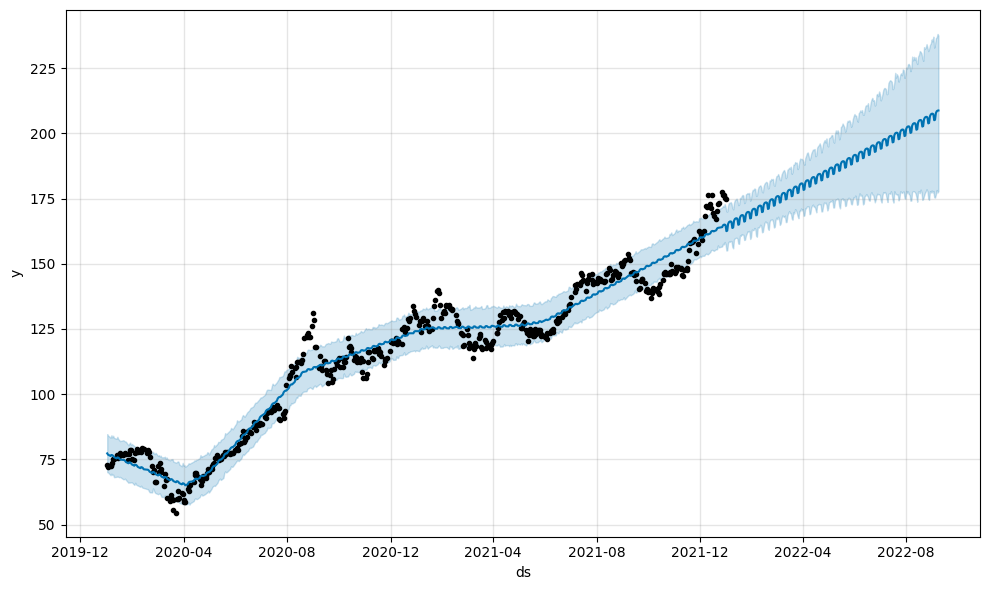

In [26]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: 데이터 준비
data = fetch_stock_data('AAPL', '2020-01-01', '2023-01-01')
data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)  # Prophet 형식에 맞게 컬럼 이름 변경

# Step 2: Train/Test 분리
train_data = data[data['ds'] < '2022-01-01']  # 2022년 1월 이전 데이터
test_data = data[data['ds'] >= '2022-01-01']  # 2022년 1월 이후 데이터

# Step 3: Prophet 모델 학습
model = Prophet()
model.fit(train_data)

# Step 4: 미래 데이터프레임 생성 및 예측
future = model.make_future_dataframe(periods=len(test_data), freq='D')
forecast = model.predict(future)

# Step 5: 시각화 - 모델 함수

model.plot(forecast)
plt.show()


- 검은 점: 실제 데이타 (학습데이터)
- 파란 선: 모델이 예측한 값 (테스트 구간 포함)
- 파란 영역: 신뢰 구간 (Confidence Interval)

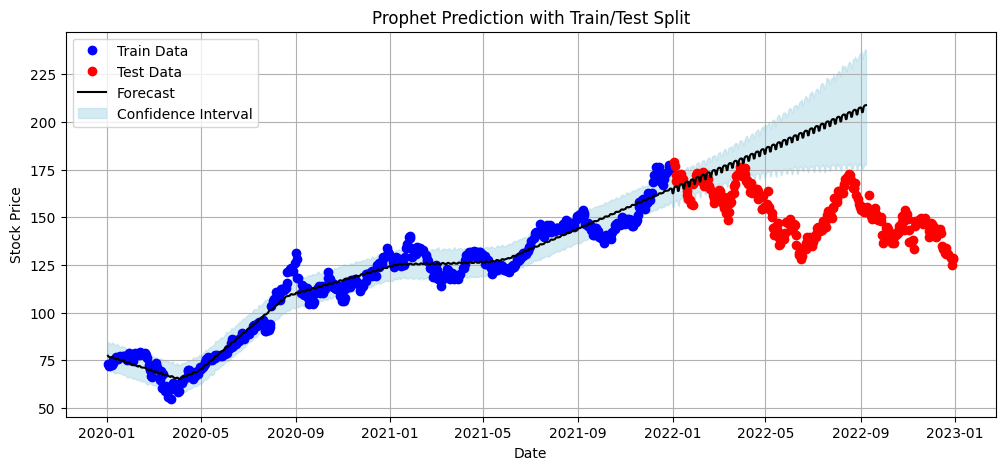

In [27]:
# 추가 시각화 - Train/Test 구간 구분
plt.figure(figsize=(12, 5))
plt.plot(train_data['ds'], train_data['y'], 'bo', label='Train Data')  # 학습 데이터
plt.plot(test_data['ds'], test_data['y'], 'ro', label='Test Data')  # 테스트 데이터
plt.plot(forecast['ds'], forecast['yhat'], 'k-', label='Forecast')  # 예측 값
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='lightblue', alpha=0.5, label='Confidence Interval')
plt.legend()
plt.title("Prophet Prediction with Train/Test Split")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.grid()
plt.show()

In [ ]:
# 성능 평가
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_true = test_data['y'].values
y_pred = forecast['yhat'][-len(test_data):].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE: {mae}, RMSE: {rmse}")

MAE: 35.179844595577386, RMSE: 41.680480894184505


## Prophet - 순차적 예측 (Sequential Prediction)
- Prophet 모델을 훈련 데이터에 맞춰 학습.
- 다음 시점 하나만 예측.
- 예측된 값을 훈련 데이터에 추가하여 다시 학습 및 다음 시점 예측.
- 테스트 데이터 전체를 순차적으로 예측.

In [28]:
# 로깅 메시지 제거
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)  # Prophet 로그 레벨 설정
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)  # cmdstanpy 로그 레벨 설정

[*********************100%***********************]  1 of 1 completed
<ipython-input-29-619fbce15bd3>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted'] = sequential_predictions  # 테스트 데이터에 예측 값 추가


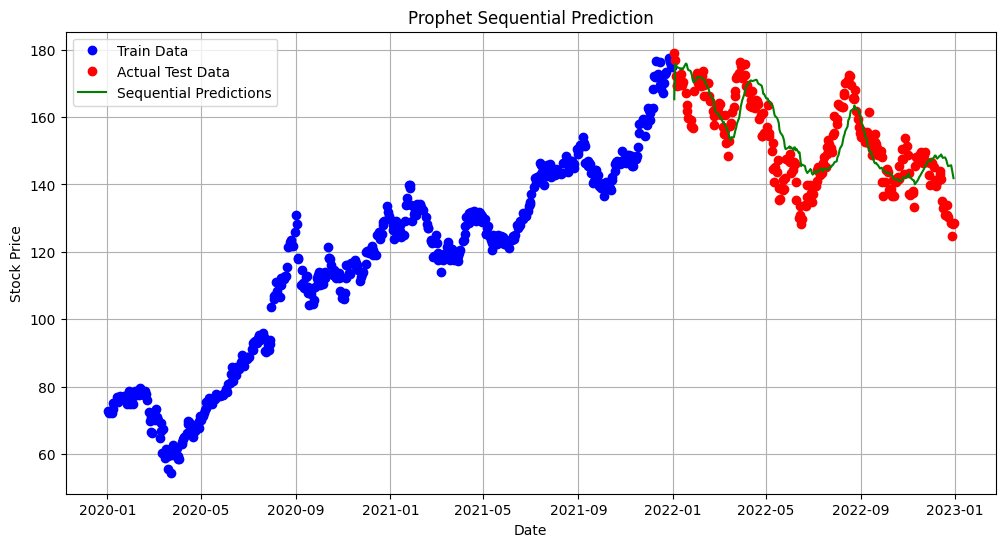

In [29]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: 데이터 준비
data = fetch_stock_data('AAPL', '2020-01-01', '2023-01-01')
data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)  # Prophet 형식에 맞게 컬럼 이름 변경

# Step 2: Train/Test 분리
train_data = data[data['ds'] < '2022-01-01']  # 2022년 1월 이전 데이터
test_data = data[data['ds'] >= '2022-01-01']  # 2022년 1월 이후 데이터

# Step 3: 순차적 예측을 위한 초기화
history = train_data.copy()  # 훈련 데이터를 초기 이력으로 설정
sequential_predictions = []  # 순차적으로 예측된 값을 저장할 리스트

for index, row in test_data.iterrows():
    # Step 4: Prophet 모델 학습
    model = Prophet()
    model.fit(history)

    # Step 5: 다음 시점 예측
    future = pd.DataFrame([{'ds': row['ds']}])  # 한 시점 예측
    forecast = model.predict(future)
    predicted_value = forecast['yhat'].iloc[0]

    # Step 6: 예측 결과 저장
    sequential_predictions.append(predicted_value)

    # Step 7: 실제 값을 history에 추가
    history = pd.concat([history, pd.DataFrame([row])], ignore_index=True)

# Step 8: 결과 시각화
test_data['Predicted'] = sequential_predictions  # 테스트 데이터에 예측 값 추가

plt.figure(figsize=(12, 6))
plt.plot(train_data['ds'], train_data['y'], 'bo', label='Train Data')  # 학습 데이터
plt.plot(test_data['ds'], test_data['y'], 'ro', label='Actual Test Data')  # 실제 테스트 데이터
plt.plot(test_data['ds'], test_data['Predicted'], 'g-', label='Sequential Predictions')  # 순차적 예측 데이터
plt.legend()
plt.title("Prophet Sequential Prediction")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.grid()
plt.show()


## LSTM 모델
- 개념: RNN 기반의 딥러닝 모델로, 시계열 데이터를 처리.
- 장점:
  - 비선형 관계를 잘 학습.
  - 시계열 데이터에서의 장기 종속성 처리 가능.
- 단점:
  - 학습 시간이 오래 걸림.
  - 더 많은 데이터가 필요.

- (예제)
  - 고정된 60일의 데이터를 기준으로 다음날 가격을 예측 (예측한 값(predicted_test)이 다시 테스트 데이터의 입력으로 사용되지는 않음.
  - 즉, 독립적인 테스트 데이터로만 다음 날의 가격을 예측하는 방식

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - loss: 0.2003 - val_loss: 0.0183
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0148 - val_loss: 0.0068
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0058 - val_loss: 0.0046
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0020 - val_loss: 0.0037
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0021 - val_loss: 0.0029
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


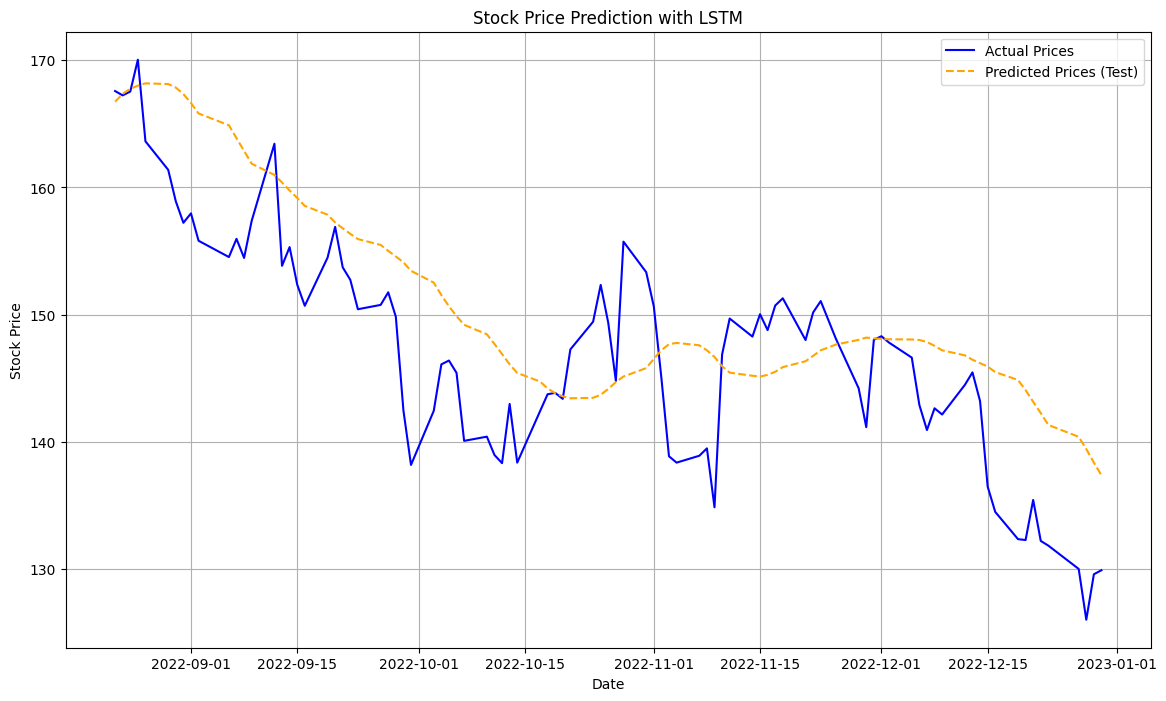

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Step 1: Fetch Historical Stock Data
def fetch_stock_data(stock_symbol, start_date, end_date):
    data = yf.download(stock_symbol, start=start_date, end=end_date)
    data = data[['Close']].copy()  # Ensure we copy the dataframe
    data.reset_index(inplace=True)  # Reset MultiIndex to single index
    data.columns = ['Date', 'Close']  # Rename columns for clarity
    data.dropna(inplace=True)  # Drop NaN values
    return data

stock_symbol = 'AAPL'
data = fetch_stock_data(stock_symbol, '2020-01-01', '2023-01-01')

# Step 2: Prepare Data for LSTM
# Use only the 'Close' prices for LSTM model
df = data[['Close']]

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df)

# Split data into training and testing sets
split_index = int(len(data_scaled) * 0.8)  # 80% for training, 20% for testing
train_data = data_scaled[:split_index]
test_data = data_scaled[split_index:]

# Create sequences for LSTM input
sequence_length = 60  # Use 60 days of data to predict the next day

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Reshape data for LSTM (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Step 3: Build LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 4: Train the Model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Step 5: Make Predictions
predicted_train = model.predict(X_train)
predicted_test = model.predict(X_test)

# Reverse the scaling
predicted_train = scaler.inverse_transform(predicted_train)
predicted_test = scaler.inverse_transform(predicted_test)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


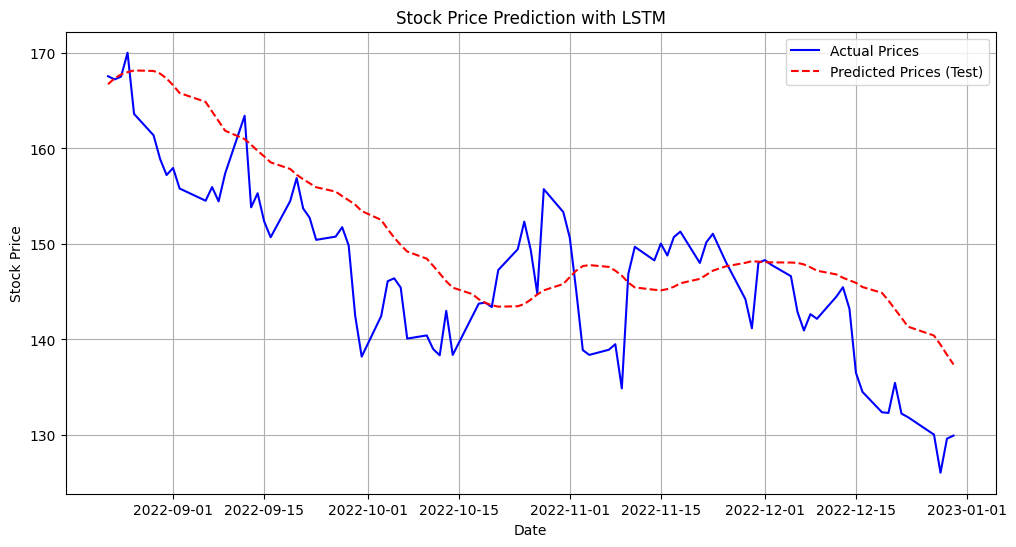

In [ ]:
# Step 6: Plot Actual vs Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(data['Date'][-len(y_test_actual):], y_test_actual, label="Actual Prices", color="blue")  # Actual prices
plt.plot(data['Date'][-len(predicted_test):], predicted_test, label="Predicted Prices (Test)", color="red", linestyle="--")  # Predicted prices
plt.title("Stock Price Prediction with LSTM")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid()
plt.show()


In [ ]:
pd.concat([data.head(3), data.tail(3)])

,Date,Close
0,2020-01-02,75.087502
1,2020-01-03,74.357498
2,2020-01-06,74.949997
753,2022-12-28,126.040001
754,2022-12-29,129.610001
755,2022-12-30,129.929993


## 강화학습
- 에이전트가 주어진 상태(예: 주가 데이터)에서 행동(예: 매수, 매도, 관망)을 선택.
- 선택한 행동에 따라 보상(예: 이익 또는 손실)을 받음.
- 보상을 극대화하는 방향으로 정책(Policy)을 학습.
- 애플(AAPL) 주식을 대상으로, **한 번에 한 주씩 매수(Market Buy)와 매도(Market Sell)**를 수행하는 시뮬레이션을 실행한다. (더 현실적인 시뮬레이션을 위해 한 번에 여러 주를 매수/매도하거나, 행동 공간을 확장하여 다양한 수량을 처리하도록 변경 가능)
- 이를 통해 에이전트가 주가의 변동성을 기반으로 한 매수 및 매도 전략을 학습하고 결과를 확인할 수 있습니다.

In [ ]:
!pip install gym pandas numpy matplotlib stable-baselines3
!pip install yfinance
!pip install shimmy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 39.9 MB/s eta 0:00:00


- Environment:
  - 강화학습 에이전트와 상호작용하는 시스템으로, 에이전트가 행동을 취하면 새로운 상태와 보상을 반환한다.
  - StockTradingEnv는 OpenAI Gym 스타일로 작성된 사용자 정의 환경.

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import gym
from gym import spaces
from stable_baselines3 import DQN
import matplotlib.pyplot as plt

# Step 1: Fetch Historical Stock Data
def fetch_stock_data(stock_symbol, start_date, end_date):
    data = yf.download(stock_symbol, start=start_date, end=end_date)
    data = data[['Close']]                        # 종가 데이터
    data['Returns'] = data['Close'].pct_change()  # 수익률 계산 (두 연속 데이터 간의 변화율)
    data.dropna(inplace=True)
    return data

stock_symbol = 'AAPL'
data = fetch_stock_data(stock_symbol, '2020-01-01', '2023-01-01')

# Step 2: Define the Stock Trading Environment
class StockTradingEnv(gym.Env):

    # 초기 상태 설정
    # 잔고(balance), 포지션(보유 주식 수), 현재단계 (시뮬레이션 현재 시점)
    def __init__(self, data):
        super(StockTradingEnv, self).__init__()
        self.data = data
        self.current_step = 0
        self.balance = 10000  # 초기 자본
        self.position = 0     # 현재 보유량
        self.done = False

        # 상태 공간: [현재 주가, 수익률, 보유량]
        # spaces.Box()는 OpenAI Gym 라이브러리에서 제공하는 클래스 중 하나로, 연속형 상태 공간 또는 연속형
        # 행동 공간을 정의하는 데 사용된다. 이를 통해 환경의 상태나 행동이 특정 범위 내의 실수(float) 값으로
        # 표현될 수 있다.
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(3,), dtype=np.float32)

        # 행동 공간: [0 = 관망, 1 = 매수, 2 = 매도]
        self.action_space = spaces.Discrete(3)

    def reset(self):
        self.current_step = 0
        self.balance = 10000
        self.position = 0
        self.done = False
        return self._next_observation()

    def step(self, action):
        prev_price = self.data['Close'].iloc[self.current_step].item()

        # 행동에 따른 상태 업데이트
        if action == 1:  # 매수
            if self.balance >= prev_price:  # 잔고가 충분한 경우
                self.position += 1          # 보유 주식 1 증가
                self.balance -= prev_price  # 잔고에서 매수 가격 차감
        elif action == 2:  # 매도
            if self.position > 0:           # 보유 포지션이 있을 경우
                self.position -= 1          # 보유 주식 1 감소
                self.balance += prev_price  # 잔고에 매도 가격 추가

        # 다음 스텝으로 이동
        self.current_step += 1
        if self.current_step >= len(self.data) - 1:
            self.done = True

        # 보상 계산 (매수 후 주가 상승 → 긍정적 보상. 매도 후 주가 하락 → 긍정적 보상.)
        current_price = self.data['Close'].iloc[self.current_step].item()
        reward = (current_price - prev_price) * self.position    # 주가 변화에 따른 보상
        return self._next_observation(), reward, self.done, {}   # next_state, reward, done

    def _next_observation(self):
        return np.array([
            self.data['Close'].iloc[self.current_step].item(),
            self.data['Returns'].iloc[self.current_step].item(),
            self.position
        ], dtype=np.float32)

# Step 3: Train the DQN Model
# 실제 데이터로 훈련됨
# MlpPolicy: 다층 퍼셉트론(MLP) 신경망을 사용하여 상태-행동 값을 학습
env = StockTradingEnv(data)
model = DQN("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=50000)  # 에이전트가 50,000번의 행동을 취하며 최적화된 정책을 학습.
                                    # 여러 개의 episode 로 구성
model.save("stock_trading_agent")

# Step 4: Test the Trained Model
state = env.reset()
done = False

actions = []         # 에이전트의 행동 기록
prices = []          # 각 스텝의 주가
balances = []        # 각 스텝의 잔고 기록
positions = []       # 보유 주식 수

while not done:
    action, _states = model.predict(state)
    state, reward, done, _ = env.step(action)

    # 행동 및 현재 상태 기록
    actions.append(action)
    prices.append(state[0])     # 현재 주가
    balances.append(env.balance)
    positions.append(env.position)


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


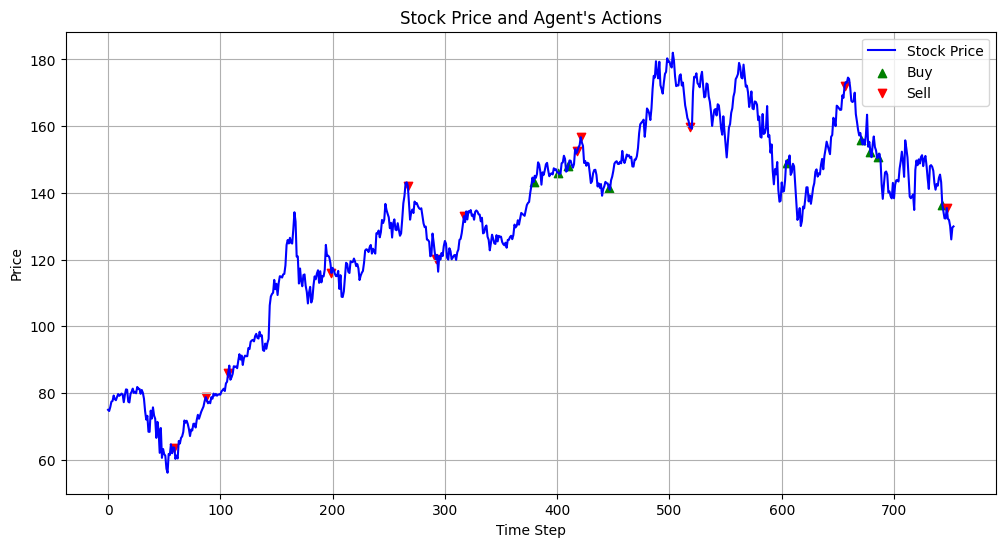

In [ ]:
# Step 5: Plotting Results
# 매수 및 매도 포인트 계산
buy_points = [prices[i] if actions[i] == 1 else None for i in range(len(actions))]
sell_points = [prices[i] if actions[i] == 2 else None for i in range(len(actions))]

# 주가 데이터와 행동 플롯
plt.figure(figsize=(12, 6))
plt.plot(prices, label="Stock Price", color="blue")
plt.scatter(range(len(prices)), buy_points, color="green", label="Buy", marker="^", alpha=1)
plt.scatter(range(len(prices)), sell_points, color="red", label="Sell", marker="v", alpha=1)
plt.title("Stock Price and Agent's Actions")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()


1. 행동 패턴 (Stock Price and Agent's Actions)
- 매수/매도 시점:
  - 에이전트는 상승 추세 후에 매수하거나, 하락 추세에서 매도하는 경우가 보임.
  - 일부 행동은 최적의 타이밍이 아닌 경우도 있음.
- 행동 빈도:
  - 매수와 매도 횟수가 비교적 적음.
  - 많은 구간에서 관망(Hold) 상태를 유지.
- 최적화 부족:
  - 에이전트의 행동이 시장 흐름과 잘 맞지 않는 구간이 존재:
    - 예: 상승 초기에 매수하지 않고, 후반부에 매수하는 행동.
    - 하락 초기에 매도하지 않고, 후반부에 매도하는 행동.


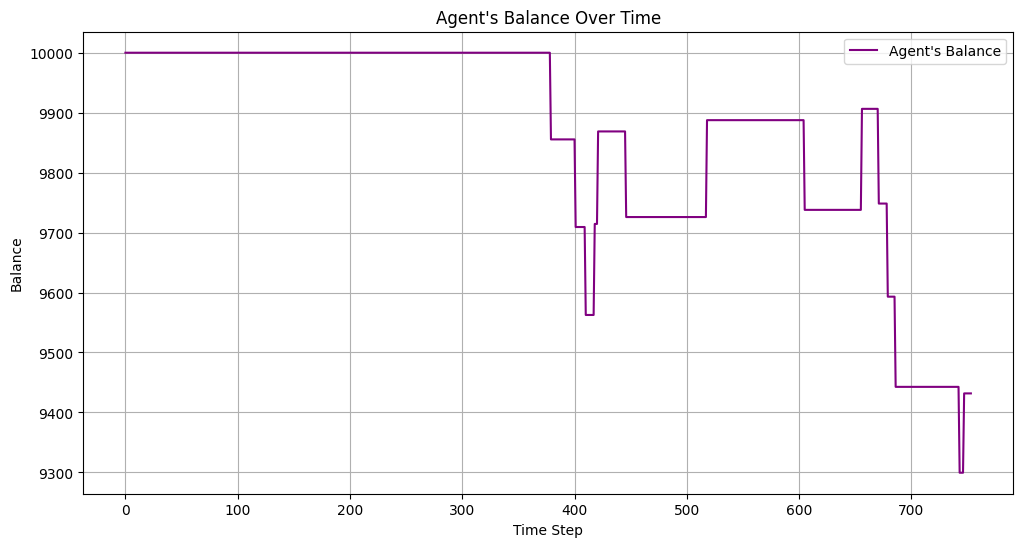

In [ ]:
# 잔고 변화 플롯
plt.figure(figsize=(12, 6))
plt.plot(balances, label="Agent's Balance", color="purple")
plt.title("Agent's Balance Over Time")
plt.xlabel("Time Step")
plt.ylabel("Balance")
plt.legend()
plt.grid()
plt.show()


2. 잔고 변화 (Agent's Balance Over Time)
- 잔고 감소:
  - 학습 과정에서 잔고가 지속적으로 감소.
  - 이는 에이전트가 손실을 보고 있다는 것을 의미.
- 매수/매도에 따른 변화:
  - 잔고의 급격한 하락은 잘못된 매수 또는 매도로 인해 손실이 발생한 것으로 보임.
  - 예: 고점에서 매수 후 가격이 하락하거나, 저점에서 매도 후 가격이 상승.
- 관망 구간:
  - 잔고가 일정하게 유지되는 구간이 많음 → 관망 상태에서 잔고 변화가 없음.

### 개선점 ###
1. 보상 함수 개선
  - 현재 보상 함수는 단순히 주가 변화와 보유 주식 수에 의존:

     ```reward = (current_price - prev_price) * self.position```
  - 개선 방안:
    - 장기적 수익률을 고려한 보상: 보유 기간 동안의 수익률을 포함.
  - 거래 비용 반영: 매수/매도 시 수수료 또는 세금을 추가.
  - 행동 빈도 페널티: 불필요한 매수/매도 행동에 페널티를 부여.

2. 행동 공간 확장
  - 현재는 단순히 매수, 매도, 관망만 가능.
  - 한 번에 여러 주를 거래할 수 있도록 행동 공간을 확장

     ```self.action_space = spaces.Discrete(5)  # 예: 1주, 5주 단위로 매수/매도 ```
3. 더 긴 학습 시간
  - 학습 타임스텝(total_timesteps=50000)을 늘려 더 많은 데이터로 학습.
  - 초기 탐험(Exploration) 단계를 충분히 늘려 다양한 행동을 시도하게 함.
4. 데이터 다양화
  - 단일 주식 데이터(AAPL) 대신 다양한 주식 데이터를 사용하여 일반화된 전략 학습.
  - 예: 여러 주식 포트폴리오를 구성하거나, 다른 시계열 데이터를 포함.
5. 강화학습 알고리즘 개선
  - DQN 대신 더 정교한 알고리즘(PPO, A2C 등)을 사용하여 학습 성능 향상.
  - PPO(A2C)는 연속적이고 더 복잡한 행동 공간에서도 더 안정적인 학습 가능.
6. 환경의 상태 공간 확장
  - 현재 상태 공간은 [현재 주가, 수익률, 보유량]으로 제한.
  - 상태 공간에 다음 요소를 추가:
    - 이동 평균(Moving Average): 주가 추세를 더 명확히 파악.
    - 거래량(Volume): 시장의 유동성 고려.
    - 상대 강도 지수(RSI): 과매수/과매도 여부 파악.

# Assignment:

과제 개요
1. 목표:
  - 주어진 데이터로 주가를 예측하고, 다양한 예측 모델을 비교한 후, Excel 보고서를 생성해 결과를 정리.
2. 구성 요소:
  - 데이터 전처리 및 시각화
  - 예측 모델 학습 및 결과 비교 (최소 2개 이상의 모델)
  - Excel 파일 생성: 예측 결과, 그래프, 모델 비교표 포함
  - 보고서 요약 작성

과제단계
1. 데이터 제공 및 전처리
  - 데이터: Yahoo Finance에서 다운로드한 주식 데이터 (e.g., S&P500, 특정 기업)
  - 데이터 정리와 전처리
    - 날짜별 주가 차트 생성
    - 결측치 처리 (있다면)
    - 학습 데이터와 테스트 데이터로 분리
2. 모델 학습
  - 두 가지 이상 또는 하이브리드 모델 (권장)을 사용하여 예측:
    - LSTM: 딥러닝 모델로 시계열 데이터 예측
    - ARIMA: 통계적 모델
    - Prophet 또는 간단한 선형 회귀 추가 가능
    - Hybrid Model: ARIMA/Prophet (장기추세) + 머신러닝/딥러닝 모델 (단기변동 예측)
  - 각 모델의 결과를 시각화하고 비교:
    - 예측 값과 실제 값의 차이를 보여주는 그래프
    - RMSE 또는 MAE와 같은 평가 지표 계산
3. Excel 보고서 생성
  - Excel 파일 작성:
    - 예측 결과 요약 (테이블 형태로 정리)
    - 예측과 실제 주가의 비교 그래프 삽입
    - 모델 성능 비교표 작성
  - Excel 보고서 항목 예시:
    - 시트 1: 데이터 요약: 학습 데이터와 테스트 데이터의 기간, 분포 등
    - 시트 2: 예측 결과: 각 모델의 예측 값, 실제 값, 오차
    - 시트 3: 그래프: 날짜별 실제 값과 예측 값 비교 그래프
    - 시트 4: 모델 비교: RMSE, MAE 등 지표로 모델 성능 비교
4. 최종 보고서 요약
  - 보고서 내용:
    - 프로젝트 목표
    - 데이터 및 모델 설명
    - 결과 분석 (예측 성능 비교, 실제 데이터와의 차이)
    - 결론 및 개선 가능성 제안
  - Excel 보고서를 기반으로 간단한 PPT나 Word 보고서 요약 작성.
  - 예측 결과를 요약한 간단한 보고서를 작성하고 이를 경영 전략에 어떻게 활용할 수 있을지 결론.



# Exercise

- pd.pct_change(): 연속 데이터의 변화율을 계산 (percent change)

In [ ]:
import pandas as pd

data = pd.DataFrame({
    'Price': [100, 105, 110, 120, 115]
})

# 연속된 값의 변화율 계산: (current_val - pre_val)/prev_val
data['Percent Change'] = data['Price'].pct_change()
print(data)

   Price  Percent Change
0    100             NaN
1    105        0.050000
2    110        0.047619
3    120        0.090909
4    115       -0.041667


- 주가 데이터에서 일일 수익률 계산:

In [ ]:
import yfinance as yf

data = yf.download('AAPL', start='2023-01-01', end='2023-01-10')
data['Daily Returns'] = data['Close'].pct_change()
print(data[['Close', 'Daily Returns']])

[*********************100%***********************]  1 of 1 completed

Price            Close Daily Returns
Ticker            AAPL              
Date                                
2023-01-03  125.070000           NaN
2023-01-04  126.360001      0.010314
2023-01-05  125.019997     -0.010605
2023-01-06  129.619995      0.036794
2023-01-09  130.149994      0.004089


- spaces.Box(): OpenAI Gym 라이브러리에서 제공하는 클래스 중 하나로, 연속형 상태 공간 또는 연속형 행동 공간을 정의하는 데 사용.

In [ ]:
# 단순 연속형 상태 공간 정의

from gym import spaces

# 상태 공간: 값이 [-1, 1] 사이의 3차원 벡터
state_space = spaces.Box(low=-1.0, high=1.0, shape=(3,), dtype=np.float32)

print("State Space:")
print(state_space)

# 샘플 값 생성
sample = state_space.sample()
print("Sample State:", sample)

State Space:
Box(-1.0, 1.0, (3,), float32)
Sample State: [-0.33671418  0.38855466 -0.87203103]


- Regular Expression

In [ ]:
import re
text = "-> $156.78"
match = re.search(r"->\s*\$(\d+\.\d+)", text)    # Regex with a capturing group ('()' 로 정의)
print(match, "\n", match.group(0), "\n", match.group(1))    # group(0) 는 전체

<re.Match object; span=(0, 10), match='-> $156.78'> 
 -> $156.78 
 156.78
